In [1]:
# Copyright © 2020, Johan Vonk
# SPDX-License-Identifier: MIT

In [17]:
%matplotlib inline
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from sklearn.manifold import MDS
from sklearn.metrics import pairwise_distances
import paho.mqtt.client as mqtt
from threading import Timer
import json
from config import username, password
import seaborn as sns

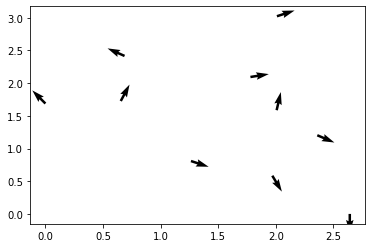

In [3]:
measured=np.array([
    [0, 37.9, 92.2, 95.2, 56.6, 95.5, 73.5, 56.7, 121.2, 73.9],
    [0, 0, 54.7, 71.8, 44.4, 59.4, 41.6, 21.9, 89.5, 46.8],
    [0, 0, 0, 60.3, 67.6, 27.3, 45.8, 42.3, 65.1, 43.5],
    [0, 0, 0, 0, 40.4, 87.1, 94.8, 78.9, 125.4, 25.4],
    [0, 0, 0, 0, 0, 86.9, 81.3, 61.5, 123.0, 28.0],
    [0, 0, 0, 0, 0, 0, 29.1, 39.1, 28.3, 67.2],
    [0, 0, 0, 0, 0, 0, 0, 20.6, 48.6, 70.0],
    [0, 0, 0, 0, 0, 0, 0, 0, 67.6, 53.5],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 105.5],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
])
measured*=0.0254
measured+=measured.T
model = MDS(n_components=2, metric=True, dissimilarity='precomputed', random_state=1, n_init=1000, max_iter=1000)
positions = model.fit_transform(measured)
positions -= positions[8]
positions[:, 1]*=-1
theta=np.radians(221)+math.atan2(positions[5,1],positions[5,0])
positions=positions.dot([[np.cos(theta), -np.sin(theta)],
                         [np.sin(theta),  np.cos(theta)]])
positions[:,0]-=positions[3,0]
angles=np.radians([18,9,-18,135,156,-59,-23,77,-90,62])
plt.quiver(positions[:,0], positions[:,1], np.cos(angles), np.sin(angles))

In [4]:
devices=pd.DataFrame(columns=("name", "address", "version", "date"))
df=pd.DataFrame(columns=("TIMESTAMP","SCANNER","ADVERTISER","TX POWER","RSSI","DISTANCE","ANGLE"))
class RepeatTimer(Timer):
    def run(self):
        while not self.finished.wait(self.interval):
            self.function(*self.args, **self.kwargs)

def switch_devices(client, devices):
    for device,payload in zip(devices["name"],np.random.choice(['scan', 'adv'],len(devices))):
        client.publish("blescan/ctrl/"+device, payload=payload)

def on_connect(client, userdata, flags, rc):
    client.subscribe("blescan/data/#")
    client.publish("blescan/ctrl", payload="who")

def on_message(client, userdata, msg):
    source=msg.topic.rsplit('/', 1)[-1]
    data = json.loads(msg.payload.decode('ASCII').replace('""','"'))
    if "name" in data and data["name"] not in devices["name"].values:
        devices.loc[len(devices)]=[data["name"],data["address"],data["version"],data["date"]]
    elif "RSSI" in data and data["address"] in devices["address"].values and source in devices["name"].values:
        sc_pos=positions[int(source.replace("esp32-",""))-1]
        advertiser=devices[devices['address']==data['address']]['name'].values[0]
        ad_pos=positions[int(advertiser.replace("esp32-",""))-1]
        dx=sc_pos[0]-ad_pos[0]
        dy=sc_pos[1]-ad_pos[1]
        df.loc[len(df)]=[pd.Timestamp.now(),source,advertiser,data["txPwr"],data["RSSI"],math.sqrt(dx**2+dy**2),(math.atan2(dy,dx)-angles[int(advertiser.replace("esp32-",""))-1]+2*np.pi)%(2*np.pi)]

client=mqtt.Client("reader")
client.on_connect = on_connect
client.on_message = on_message
client.connect('mqtt.vonk', 1883)
client.username_pw_set(username=username,password=password)
timer = RepeatTimer(60, switch_devices, args=(client,devices))
try:
    client.loop_start()
    timer.start()
except KeyboardInterrupt:
    client.loop_stop()
    timer.cancel()

In [536]:
d=df.copy()
angle_shift=(1-np.cos(2*d['ANGLE']))/d['ANGLE']*3-0.855
d['ESTIMATE']=10**((11.5366+d['TX POWER']-d['RSSI']-angle_shift)/10/2)
d['ERROR']=d['ESTIMATE']/d['DISTANCE']-1
d.to_csv(f"pact_{d['TIMESTAMP'].iloc[0].to_pydatetime().strftime('%Y%m%dT%H%M%S')}.csv")

Estimate is 37.197% off in median case.


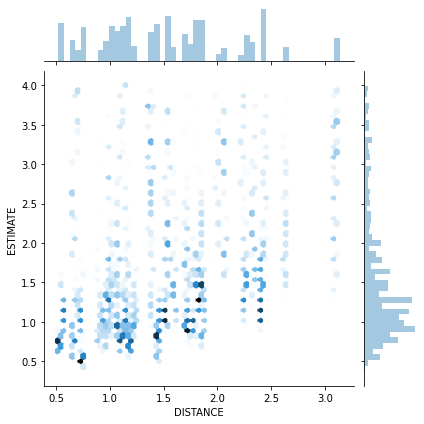

In [537]:
print("Estimate is {0:.3%} off in median case.".format(np.abs(d['ERROR']).median()))
plot_data=d.query('ESTIMATE>0 and ESTIMATE<4')
sns.jointplot(x="DISTANCE", y="ESTIMATE", data=plot_data, kind="hex")